In [ ]:
# Load the data
from pathlib import Path
import pandas as pd
import numpy as np

data_csv = Path("reviews.csv")

if not data_csv.exists():  # make sure the file exists, otherwise compile it
    from result_compiler import main as data_compiler
    data_compiler()

df = pd.read_csv(data_csv)

# Sort the sources in the DataFrame as AAAI, IJCAI then ICML, NeurIPS and JAIR, JMLR
source_order = ["AAAI", "IJCAI", "ICML", "ICLR", "NeurIPS", "JAIR", "JMLR"]
df["source"] = pd.Categorical(df["source"], source_order)
# Drop the index column
df.drop("index", axis=1, inplace=True)
# Drop the theoretical papers
df = df[df["theoretical"] == False]

# Load the enriched data
enriched_data_csv = Path("enriched_data.csv")
enriched_df = pd.read_csv(enriched_data_csv)

missing_titles_enriched = [l.strip() for l in Path("unfindable.txt").open().readlines()]

In [119]:
# Create a mapping between titles
import difflib

mapping_to_enriched_title = {}
enriched_titles = enriched_df["title"].tolist()
lowered_titles = [s.lower() for s in enriched_titles]
for title in df["title"]:
    if title in missing_titles_enriched:  # Is not present, was not findable on scopus
        continue
    if title in enriched_df["title"]:  # Easy case
        mapping_to_enriched_title[title] = title
    else:
        close_matches = difflib.get_close_matches(title.lower(), lowered_titles, cutoff=0.6)
        if len(close_matches) == 0:
            print("Could not match:", title)
            continue
        index = lowered_titles.index(close_matches[0])
        mapping_to_enriched_title[title] = enriched_titles[index]

print(len(mapping_to_enriched_title.keys()))
print(len(set([v for v in mapping_to_enriched_title.values()])))

918
918


In [120]:
for key in mapping_to_enriched_title.keys():
    value = mapping_to_enriched_title[key]
    matches = [v for v in mapping_to_enriched_title.values() if v == value]
    if len(matches) > 1:
        print(key, ":", value)
        

In [121]:
# Add citations count column and country of first authors
df["citation_count"] = None
df["country"] = None

def most_frequent(l: list):
    return max(set(l), key=l.count)

for title, mapping in mapping_to_enriched_title.items():
    enriched_row = enriched_df[enriched_df["title"] == mapping]
    df.loc[df["title"] == title, "citation_count"] = enriched_row["citedby_count"].values[0]
    aff = enriched_row["affiliation_country"].values[0]
    if isinstance(aff, str):
        countries = enriched_row["affiliation_country"].values[0].split(";")
        #df.loc[df["title"] == title, "country"] = enriched_row["affiliation_country"].values[0].split(";")[0]  # First author country affiliation
        df.loc[df["title"] == title, "country"] = most_frequent(countries)  # Most frequent country affiliation

In [122]:
# Calculate the average rating for each paper (Excluding expertise)
review_categories = ["Implementation", "Data", "Configuration", "Experimental Procedure", "Expertise"]
df["Average"] = df[review_categories[0:-1]].mean(axis=1)

In [123]:
df_reduce = df.drop(['source', 'year', 'title', 'authors', 'keywords', 'pdf_path', 'awards', 'theoretical', 'implementation_url', 'public_datasets','total_datasets', 'Implementation', 'Data', 'Configuration', 'Experimental Procedure', 'Expertise'], axis=1)
# Only use the ones with citation values
df_reduce = df_reduce[df_reduce["citation_count"].notna()]
country_id = {v:i for i, v in enumerate(df_reduce["country"].unique())}
df_reduce["country"] = df_reduce["country"].replace(country_id)

correlation = df_reduce.corr(method="kendall")
print(correlation)

                                           Implementation_appendix_mentions  \
Implementation_appendix_mentions                                   1.000000   
Implementation_checklist_mentions                                  0.031629   
Data_appendix_mentions                                             0.155678   
Data_checklist_mentions                                           -0.010154   
Configuration_appendix_mentions                                    0.177349   
Configuration_checklist_mentions                                        NaN   
Experimental Procedure_appendix_mentions                           0.109831   
Experimental Procedure_checklist_mentions                         -0.010154   
Expertise_appendix_mentions                                        0.067261   
Expertise_checklist_mentions                                            NaN   
citation_count                                                     0.031441   
country                                             

/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_56127/2552227325.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reduce["country"] = df_reduce["country"].replace(country_id)


# SCOPUS Data: Our thoughts on this study

We also conducted a brief analysis by enriching our collected data with data from SCOPUS, using Pybliometrics. We were able to enrich 854 reviews. From this data, we used the citation count and the majority country of origin of the author's affiliation to calculate the Kendall correlation with the average cost. We found that the citation count has no significant correlation with $0.05$, whereas the affiliation country only has a weak negative correlation of $-0.16$. We do recognise that making claims based on this meta information may lead to a misunderstanding between the found correlation of sensitive information, such as country of affiliation origin, and thus do not attach any claims or conclusions to this information.

In [124]:
df = df[df["awards"].isna()]
df["citation_count"] = None

for row in df.iterrows():
    title = row[1]["title"]
    if title in mapping_to_enriched_title:
        enriched_row = enriched_df[enriched_df["title"] == mapping_to_enriched_title[title]]
        #print(enriched_row["citedby_count"].values)
        if enriched_row["citedby_count"].size == 0 or enriched_row["citedby_count"].size > 1:
            print("!!", title)
            break
        df.at[row[0], "citation_count"] = enriched_row["citedby_count"].values[0]
    else:
        print("Could not find:", title)
        df["citation_count"][row[0]] = None

Analyse the relation between citation count and cost

In [125]:
years = [2022, 2023, 2024]
review_categories = ["Implementation", "Data", "Configuration", "Experimental Procedure", "Expertise"]
dimensions = review_categories[:-1]

for y in years:
    df_y = df[df["year"] == y]
    print(f"Year {y}:")
    print(df_y[dimensions ].corrwith(df_y["citation_count"], method="kendall"))
    print()

Year 2022:
Implementation           -0.102725
Data                     -0.081712
Configuration            -0.100609
Experimental Procedure    0.008752
dtype: float64

Year 2023:
Implementation           -0.062725
Data                     -0.027981
Configuration             0.023042
Experimental Procedure    0.021883
dtype: float64

Year 2024:
Implementation           -0.045379
Data                     -0.069706
Configuration             0.101842
Experimental Procedure    0.049678
dtype: float64



/Users/thijssnelleman/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


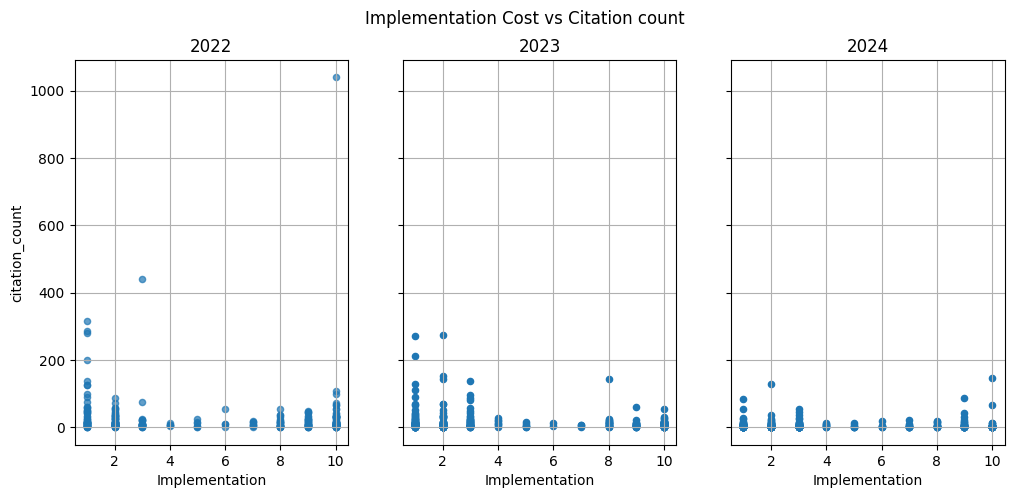

In [126]:
import matplotlib.pyplot as plt

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
x = "Implementation"
fig.suptitle(f"{x} Cost vs Citation count")


df_y = df[(df["year"] == 2022) & (df["citation_count"] < 100000)]

#sns.scatterplot(data=df_y, x=x, y='citation_count', hue="source", ax=axes[0], palette="viridis", alpha=0.7, legend=False)
df_y.plot(x=x, y='citation_count', kind='scatter', ax=axes[0], title="2022", alpha=0.7, colormap="viridis",)


df_y = df[(df["year"] == 2023) & (df["citation_count"] < 100000)]
#sns.scatterplot(data=df_y, x=x, y='citation_count', hue="source", ax=axes[1], palette="viridis", alpha=0.7, legend=False)
df_y.plot(x=x, y='citation_count', kind='scatter', ax=axes[1], title="2023")

df_y = df[(df["year"] == 2024) & (df["citation_count"] < 100000)]
#sns.scatterplot(data=df_y, x=x, y='citation_count', hue="source", ax=axes[2], palette="viridis", alpha=0.7, legend=False)
df_y.plot(x=x, y='citation_count', kind='scatter', ax=axes[2], title="2024")


for a in axes:
    a.grid(True)

plt.show()


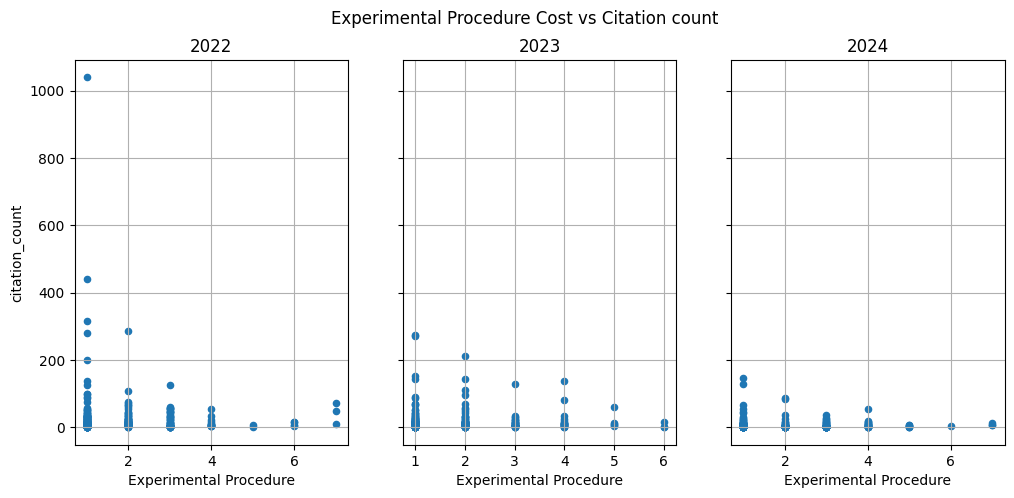

In [127]:
import matplotlib.pyplot as plt
# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
x = "Experimental Procedure"
fig.suptitle(f"{x} Cost vs Citation count")


df_y = df[(df["year"] == 2022) & (df["citation_count"] < 100000)]
df_y.plot(x=x, y='citation_count', kind='scatter', ax=axes[0], title="2022")

df_y = df[(df["year"] == 2023) & (df["citation_count"] < 100000)]
df_y.plot(x=x, y='citation_count', kind='scatter', ax=axes[1], title="2023")

df_y = df[(df["year"] == 2024) & (df["citation_count"] < 100000)]
df_y.plot(x=x, y='citation_count', kind='scatter', ax=axes[2], title="2024")


for a in axes:
    a.grid(True)

plt.show()


In [130]:

for y in years:
    for v in source_order:
        df_y = df[(df["year"] == y) & (df["source"] == v)]
        print(f"{v} {y}:", 
            round(df_y[df_y["Implementation"] == 1]["citation_count"].mean(), 2), 
            round(df_y["citation_count"].mean(), 2), 
            round(df_y[df_y["Implementation"] == 10]["citation_count"].mean(), 2)
            )
    print()


AAAI 2022: 61.38 26.2 23.67
IJCAI 2022: 4.0 18.89 14.91
ICML 2022: 22.45 18.27 22.56
NeurIPS 2022: 57.33 36.06 21.83
JAIR 2022: 57.71 15.9 10.0
JMLR 2022: 16.71 41.36 107.75

AAAI 2023: 37.3 26.21 18.42
IJCAI 2023: 9.21 7.98 8.38
ICML 2023: 29.07 16.49 7.67
NeurIPS 2023: 19.4 18.48 9.0
JAIR 2023: 13.8 7.39 2.71
JMLR 2023: 12.0 10.69 7.0

AAAI 2024: 7.25 14.22 24.0
IJCAI 2024: 3.67 3.84 4.0
ICML 2024: 1.4 2.15 0.67
NeurIPS 2024: 3.0 3.23 2.0
JAIR 2024: 9.25 3.7 2.67
JMLR 2024: 33.0 7.0 3.78

